# Visual data analysis
**Tokyo Metropolitan University, Nov. 2023**\
Malatesta Luca, GFZ Potsdam, malatest@gfz-potsdam.de\
Using data from the Iwaki River from Takahashi et al. (2023, JGR Earth Surface, https://doi.org/10.1029/2022JF006967)

**Steps**
- import `csv` datasets in python using `pandas`
- modify a `pandas` dataframe
- using `geopandas` transform WGS84 Lat Lon to UTM 54N
- visualize bullk data with `seaborn`
- explore data with up to four attributes in rich `seaborn` scatterplots
- build complex figures with multiple subplots

## A very brief introduction to *Markdown* cells
`Jupyter Lab` is an interface that lets you work on `Notebooks`. The `Notebooks` are made of `cells` like this one. When you click on the cell, it becomes editable (double click on *Markdown* cells (text) like this one and simple click on *code* cells).\
This cell is a *Markdown* cell and it can hold text and images following simple editing rules.\
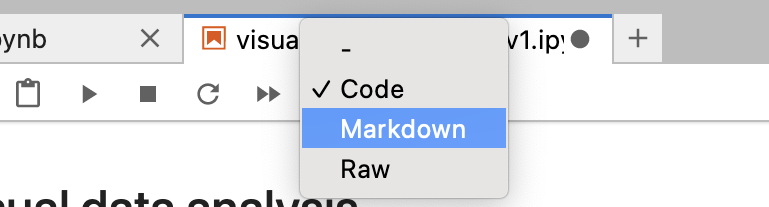


You can create a hierarchy of items using the \# sign. You can also embed images like the screenshot above. Surrounding text with single-stars makes it *italic* and double-stars makes it **bold**. Backquotes are used to `format code`. To come back to a new line you can use a single backslash.\
Mathematic equations are supported using the same syntax as in LaTeX. You can use a single `$` to surround an inline equation like this: $\tau=hS\rho g$, or use double `$$` to create an equation block like that:
$$\frac{\partial \eta}{\partial t}= -\frac{1}{\varepsilon_0}\nabla q_s$$

You can also quickly create bulletpoints with hyphens:
- like this
- that
- and that

You will work in the *code* cells where you can also add comments by writing after a single `#`. You can use the *markdown* cells for more detailed information.

## Import the necessary tools
You have already created a `conda environment` with all possible modules (tools) you might use. Think about it like going to the kitchen store and getting all the utensils and accessories that you need to cook many different dishes. They are now your environment.\
But you don't need all the tools, all the time. We are now importing only the modules we need for the task at hand. Think about it like bringing knives, measuring cups, pots, and pans you need out of the shelves and drawers. Are you preparing noodles, a cake, or grilling fish?

More info here: https://pythongis.org/part1/chapter-02/nb/05-modules.html

In [ ]:
import numpy as np                     # import and create an alias for numpy for numerical operations
import pandas as pd                    # "  pandas to handle spreadsheets
import geopandas as gpd                # "  geopandas to handle spreadsheets with GIS

import matplotlib as mpl               # "  matplotlib, the fundamental plotting toolset
from matplotlib import pyplot as plt   # "  pyplot, a very commonly used subset of tools.
import seaborn as sns                  # "  seaborn to create high-level figures <-- the main tool today

%matplotlib widget                     
# activate interactive features
# install within environment with `conda install -c conda-forge ipympl`
#                              or `pip install ipympl`

## Import csv files to `pandas`
We will store and manipulate data in a `dataframe` (spreadsheet) using the `pandas` data analysis library. This is a very common, and powerful, library and has many built-in mathematical functions. It also handles `strings` of text besides numerical values. In rare occasions we can take values out of the `dataframe` for more advanced modifications before reinserting them.\
The standard data format for import is `csv`. The `seaborn` visualization toolbox is best used together with a `pandas dataframe`.

ʕ　·ᴥ·ʔ人ʕ·ᴥ·　ʔ\
Introduction material here: https://pandas.pydata.org/docs/getting_started/intro_tutorials/index.html 

I have modified the supplementary data from Takahashi et al. (2023) such that all parameters are interpolated along the same river coordinates. You can download the original dataset in the supplementary information of the article.

In [ ]:
df_river = pd.read_csv('Iwaki_River_All.csv')  # import a csv in a dataframe
df_river    # output the dataframe

### Modify a `pandas` dataframe
We can directly modify the dataframe to prepare for the analysis.
- rename columns for clarity and brevity
- create logarithmic values for variables that have exponential growth (needed for plots where log axes are not an option)

In [ ]:
# rename columns for length or clarity
df_river = df_river.rename(columns={"Bankfull channel w [m]":"Width [m]",
                                    "Bankfull flow d [m]":"Depth [m]",
                                    "omega [W/m2]": "Stream power [W/m2]"})
                                    
# insert a log version of area and stream power for later
df_river.insert(7,  "log Area",         np.log(df_river["Area [m2]"].values))
df_river.insert(13, "log Stream power", np.log(df_river["Stream power [W/m2]"].values))
                                    
df_river

## Use `geopandas` to handle GIS information
`Geopandas` is a modification `pandas` to handle geographic information. In short, it adds a `geometry` column to the dataframe that keeps track of coordinates and their reference system. `Geopandas` does not have all the built-in tools of `pandas` and here we will switch back to pandas once we have done the necessary GIS modifications.\
To identify coordinate reference systems (`crs`), we use EPSG codes. The EPSG code for the Coordinate Reference Frame of WGS84 Lat/Lon is `4326` and UTM 54N (Japan) is `3100`.

More information here: https://geopandas.org/en/stable/getting_started/introduction.html

In [ ]:
# create a geodataframe from the pandas df, and identify which columns provide coordinates, assign the coordinate reference system
gdf_river = gpd.GeoDataFrame(df_river, geometry = gpd.points_from_xy(df_river.Longitude, df_river.Latitude), crs='epsg:4326')
gdf_river

### Reproject the Lat/Lon coordinates to UTM 
Here we modify the coordinate system of the dataset. This will update the `geometry` column only. Since we want to go back to a `pandas` dataframe, we create dedicated columns for the UTM coordinates.

In [ ]:
# reproject to UTM 54N (epsg:3100), this only affects the geometry column
gdf_river = gdf_river.to_crs("EPSG:3100")

# add the UTM coordinates in columns.
gdf_river['x'] = gdf_river.geometry.x
gdf_river['y'] = gdf_river.geometry.y

gdf_river

In [ ]:
# transform the gdfs back to pandas df for extended functionality
df_river = pd.DataFrame(gdf_river.drop(columns=(['Longitude','Latitude','geometry'])))

## Visual data exploration
That's all for the data preparation! Now we can focus on displaying the data collected by Takahashi et al. (2023). The various plots below represent only a small fraction of the different possible options. The type of plot you choose depends heavily on the type of data you have.

Colors play a particularly important role to properly display quantitative information, you will find some resources here:\
https://seaborn.pydata.org/tutorial/color_palettes.html \
https://matplotlib.org/stable/users/explain/colors/colormaps.html




### Start with a basic plot using `matplotlib`
`matplotlib` is the fundamental library to plot information on Python. Other high-level tools, such as `seaborn` are built upon `matplotlib`. We will use `matplotlib` tools to handle the frames in which we display information.\
The first step is to create a figure (`fig`) and an axis (`ax`) object. We will use them to identify where we want to plot data and to modify attributes of the figures.\
We also need to extract information from the `dataframe` to use as an input for the `matplotlib` command.

In [ ]:
fig, ax = plt.subplots()     # create handles for the figure and axis object using the function `subplots` 

x = df_river['x'].values   # extract x-coordinates from dataframe (right side of equation can also be directly written in the plot command) 
y = df_river['y'].values   # extract y-coordinates from dataframe

ax.scatter(x,y)            # plot the coordinates as a scatter on the axis (`ax`) of the figure

ax.axis('equal')           # set equal axes as we work in UTM

### Plotting with `seaborn`

`seaborn` is a powerful library that incorporates a lot of visual formatting behind the scenes and offers very useful **built-in statistical tools**.

Check the gallery here:
https://seaborn.pydata.org/examples/index.html

#### Scatter plot with `seaborn` vs `matplotlib`
We will create a figure with two side-by-side plots for comparison. For this we will add arguments in the `subplots` function.\
In `seaborn` we specify the name of the dataframe as data source and directly reference to the titles of the columns to call the elements we want to plot. The axis on which to draw the figure is also indicated as an argument in the plotting function.

Finally we can get the habit of always adding `plt.tight_layout()` at the end of each plotting cell. This makes sure that everything fits within the frame of the figure without any overlap.

In [ ]:
sns.set_theme()   # set the seaborn basic theme as a default (light grey background with white grid)

# create a figure and define the axes within it, set two axes side-by-side
fig, [ax1, ax2] = plt.subplots(figsize=(9, 4),ncols=2)

# matplotlib scatter, using the coordinates extracted above and painting the dots with elevation
ax1.scatter(x, y, c=df_river['Elevation [m]'].values, s=3)

# now using `seaborn` on the ax2, check how the data input differs
sns.scatterplot(x='x',y='y',data=df_river,hue='Elevation [m]',linewidth=0,s=5,ax=ax2)
# `s` sets the size of the dots
# `linewidth` sets the thickenss of a the outline of each dot. Set to zero when the points are overlapping closely

ax1.axis('equal')
ax2.axis('equal')
plt.tight_layout() # important to pack everything within the frame

#### `pairplot` is a very powerful first step to explore data
This allows us to identify first order trends.
Note that this function takes care of creating figure and axes. We cannot specify certain axes to be in log and so we will use the logarithmic values created earlier.

If you do not specify `x_vars` and `y_vars`, all the columns of your dataframe will be compared on both x and y axes, it can be a lot! `x_vars` and `y_vars` do not need to be the same or have the same length.\
The argument `hue` is critical. It can handle categorical values (strings) as well as numerical ones. Try different values.\
With `kind` you can swap the default scatter for a heat map, a kernel density estimate, or a add a regression line.\
`height` sets the height of an individual subplot, adjust it to keep a manageable size.\
Because `pairplot` is a little special, you have to use the argument `plot_kws` to modify the style of the comparison plots, and `diag_kws` for the plots in the diagonal. For example, use `plot_kws={"s": 5}` to change the size of the dots to a value of 5.

More details: https://seaborn.pydata.org/generated/seaborn.pairplot.html

In [ ]:
sns.pairplot(df_river,
             x_vars = ["Elevation [m]", "log Area", "Slope", "Width [m]", "log Stream power", "HS angle [deg]"],
             y_vars = ["Elevation [m]", "log Area", "Slope", "Width [m]", "log Stream power", "HS angle [deg]"],
             hue = 'Basin',
             height = 1.5)

#### Detailed examinations with `scatterplot`
`scatterplot` allows us to explore up to five variables in the same chart using both axes, color, marker size, and marker style.\
We should be careful not to overwhelm the graph with information, but this usually can result in a compact overview of core trends in your data.

`alpha` is the argument to control transparency: 1 = fully opaque, 0 = fully transparent.\
We revert back to a `matplotlib` command to place the legend outside of the plot frame. By default, `seaborn` will place it in the least crowded corner of your plot, but this might still cover some datapoints:\
`plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)`\
More details here: https://matplotlib.org/stable/users/explain/axes/legend_guide.html

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
# categorical hue
sns.scatterplot(x='Width [m]',y='Slope',data=df_river,hue='Rock',size='log Stream power',alpha=0.6,linewidth=0,ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
# numerical hue
sns.scatterplot(x='Width [m]',y='Slope',data=df_river,hue='Depth [m]',size='log Stream power',alpha=0.6,linewidth=0,ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
# set an axis to logarithmic space
plt.setp(ax, yscale='log')
sns.scatterplot(x='Slope',y='Stream power [W/m2]',data=df_river,hue='Rock',alpha=0.6,linewidth=0,ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

#### `histplot` and `kde` to explore further data attributes
As mentioned above, a great advantage of `seaborn` is the built-in statistical toolsets. We can directly plot kernel density estimates (`kde`) that are automatically calculated from the dataset. Different histograms allow us to bin large numbers of data points to explore and compare their distribution easily.

When we start plotting multiple elements on top of each other, we can use the argument `zorder` to define their relative position. `zorder=0` places the graphic behind the grid, `zorder=1` is right above the grid. Any further increment places the object further above.

In [ ]:
# here, we combine a heat map using histplot and a subtle scatter plot to show the actual data.
fig, ax = plt.subplots(figsize=(4, 4))
plt.setp(ax, yscale='log')
sns.scatterplot(x='Slope',y='Stream power [W/m2]',color='black',s=3,data=df_river,ax=ax,zorder=2)
sns.histplot(x='Slope',y='Stream power [W/m2]',bins=20,data=df_river,ax=ax,zorder=1)
plt.tight_layout()

#### Saving a figure
To save a figure, we call its handle and set the name and format under which to save it:

In [ ]:
fig.savefig('Name_of_the_figure.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(x='Slope',y='HS angle [deg]',data=df_river,hue='Rock',alpha=0.6,ax=ax)
plt.tight_layout()

#### Examine different components in multiple subplots
Sometimes the data you want to inspect crowds a figure and makes comparison hard if everything is plotted in the same frame. In these cases, it is useful to breakdown the components in subplots.

We use `GridSpec` to define a set of tiles within a single figure and we will occupy these tiles with different axes.\
To guarantee that all axes share the same limits, we specify `set_xlim` and `set_ylim` for each axis.

I order to select a subset of the data for plotting, we can use the commnad `query`, e.g. `df.query("Rock == 'sediment' ")`\
more information about `query` https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html

Including a variable in the title: there are multiple ways to incorporate the value of a variable into a string. Here we use the `%i` sign as an anchor to insert an integer right there and we indicate the variable in question right after the string and using the same `%` anchor. `%1.2f` would insert a float with two decimal precision.

In [ ]:
# set the theme with a white background for filled kdes
sns.set_theme(style="ticks")  

# more complex outline of a figure with three subplots
fig = plt.figure(figsize=(8,5))
gs  = mpl.gridspec.GridSpec(2, 3, figure=fig) # set a grid of two rows and three columns in the figure
ax1 = fig.add_subplot(gs[:,0:2])              # ax1 occupies both rows in the first two columns
ax2 = fig.add_subplot(gs[0,-1])               # ax2 occupies the tile of the top row and last column 
ax3 = fig.add_subplot(gs[1,-1])               # ax3 occupies the tile of the bottom row and last column

sns.scatterplot(x='Slope',y='HS angle [deg]',data=df_river,hue='Rock',ax=ax1)
sns.kdeplot(x='Slope',y='HS angle [deg]',data=df_river,hue='Rock',alpha=0.3,ax=ax1)
sns.kdeplot(x='Slope',y='HS angle [deg]',data=df_river.query('Rock == "Meta"'),cmap='Blues',fill=True,ax=ax2)
sns.kdeplot(x='Slope',y='HS angle [deg]',data=df_river.query('Rock == "Granite"'),cmap='YlOrBr',fill=True,ax=ax3)

# axes should all have the same limites
HS_max = df_river['HS angle [deg]'].values.max()
S_max  = df_river['Slope'].values.max()

ax1.set_xlim(-0.05, 1.1*S_max)
ax2.set_xlim(-0.05, 1.1*S_max)
ax3.set_xlim(-0.05, 1.1*S_max)
ax1.set_ylim(0, 1.2*HS_max)
ax2.set_ylim(0, 1.2*HS_max)
ax3.set_ylim(0, 1.2*HS_max)

ax1.set_title('hillslope angle and channel slope, n=%1.0f'%(len(df_river)) )
ax2.set_title('Metamorphic n=%1.0f'%(len(df_river.query("Rock == 'Meta'"))) )
ax3.set_title('Granite  n=%1.0f'%(len(df_river.query("Rock == 'Granite'"))) )

plt.tight_layout()

#### `violin` plots to compare distributions

Finally we see how to easily output a violin plot which amongst the best ways to represent the distribution of two categories relative to another. As you can see, the input code is very short.

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.set_theme()
sns.violinplot(x="Rock", y="HS angle [deg]", data=df_river, ax=ax)
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.violinplot(x="Basin", y="HS angle [deg]", hue="Rock", split=True, data=df_river, ax=ax)
plt.tight_layout()

## Aditional data analysis exercise splitting the rivers
In their study, Takahashi et al. (2023) highlight the presence of knickpoints along these and the morphological differences downstream and upstream from them. You have maybe already noticed the knickpoints when we plotted the elevation of the streams along distance or chi earlier in `pairplot`.\
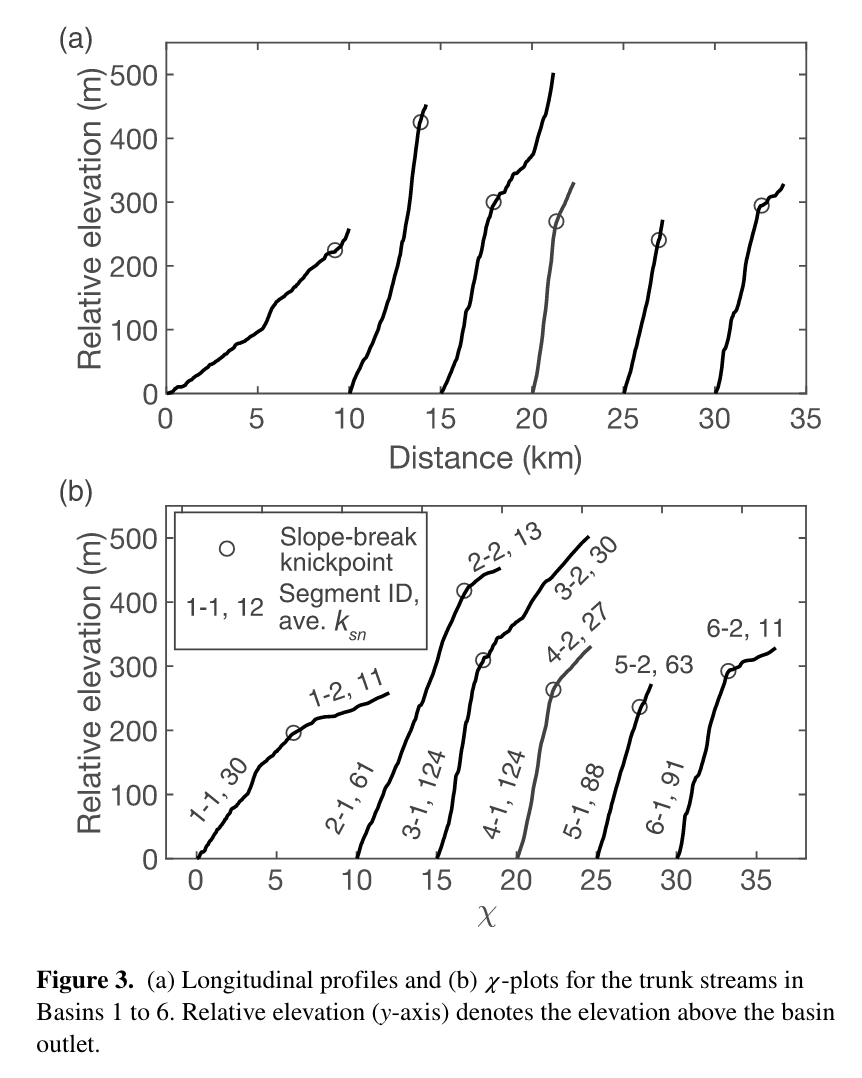

Here, we will identify the location of the knickpoints and accordingly label the downstream and upstream reaches of each river. This way we can repeat part of the analysis of Takahashi et al. (2023) where they show the higher river steepness downstream of knickpoints:\
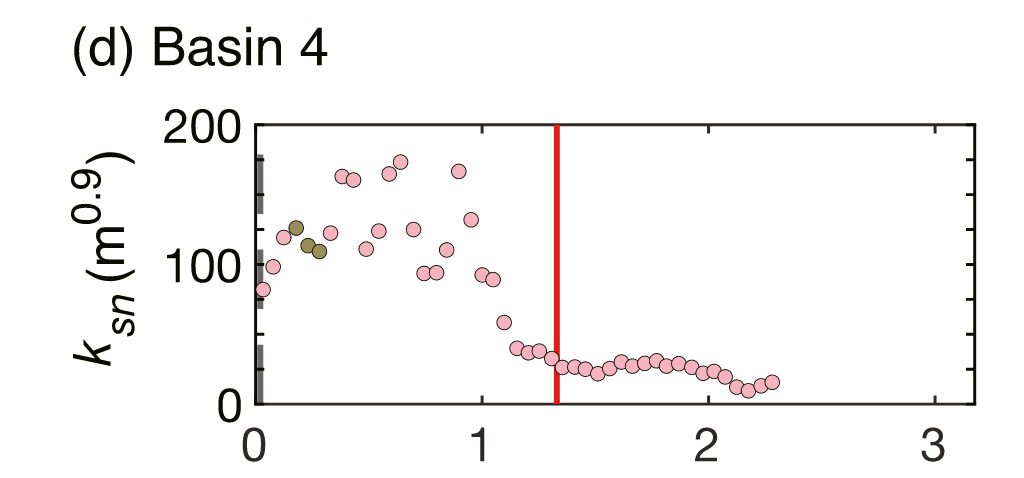\
**We are working on a modified dataset** as I interpolated the four initial tables in a single one for ease of use. We will not be able to exactly reproduce river profile figures to identify the knickpoints.

And the difference in hillslope angle upstream and downstream from them:\
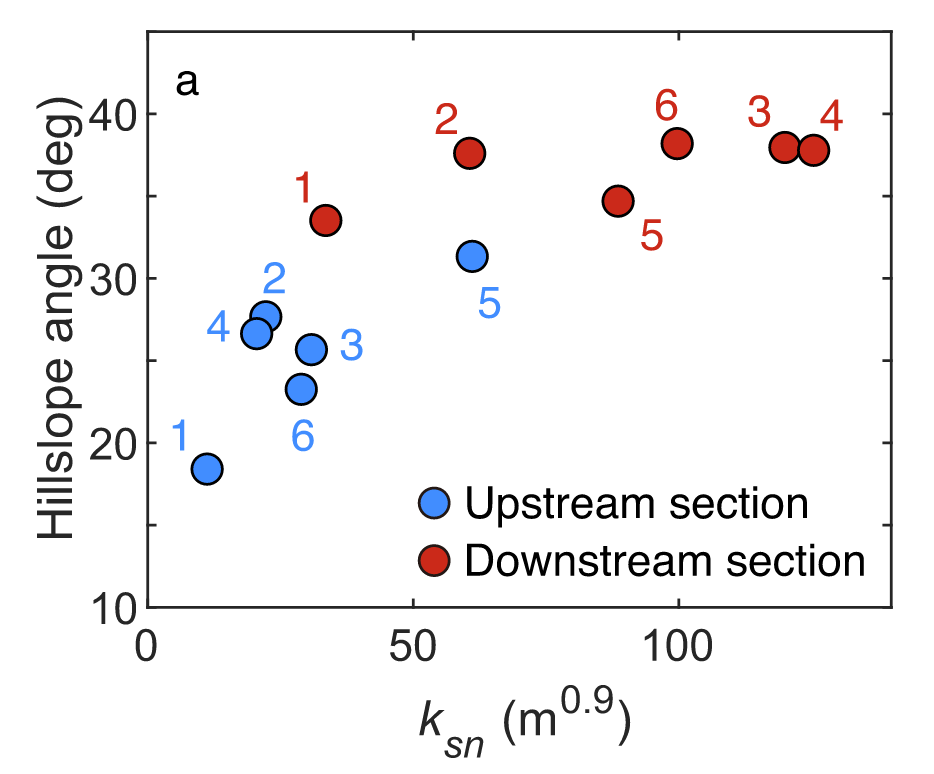

### Defining the upstream/downstream river reaches
#### Identify the knickpoints
We will start by plotting the rivers to identify the knickpoint locations.

In [ ]:
# plot the six rivers in a 2x3 mosaic.
fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(figsize=(8, 5),ncols =3, nrows =2)

sns.lineplot(x='Distance [m]',y='Elevation [m]',data=df_river.query("Basin == 'Basin 1'"), markers=True,ax=ax1)
sns.lineplot(x='Distance [m]',y='Elevation [m]',data=df_river.query("Basin == 'Basin 2'"), markers=True,ax=ax2)
sns.lineplot(x='Distance [m]',y='Elevation [m]',data=df_river.query("Basin == 'Basin 3'"), markers=True,ax=ax3)
sns.lineplot(x='Distance [m]',y='Elevation [m]',data=df_river.query("Basin == 'Basin 4'"), markers=True,ax=ax4)
sns.lineplot(x='Distance [m]',y='Elevation [m]',data=df_river.query("Basin == 'Basin 5'"), markers=True,ax=ax5)
sns.lineplot(x='Distance [m]',y='Elevation [m]',data=df_river.query("Basin == 'Basin 6'"), markers=True,ax=ax6)
plt.tight_layout()

In [ ]:
# create a new dataframe to hold the knickpoint information
df_kp = pd.DataFrame({'Basin': ['Basin 1','Basin 2','Basin 3','Basin 4','Basin 5','Basin 6']})

Dist_kp = np.array([6100,    # Basin 1
                    2820,    # Basin 2
                    2700,    # Basin 3
                    1000,    # Basin 4
                    2150,    # Basin 5
                    2450])   # Basin 6
df_kp['Distance'] = Dist_kp
df_kp

In [ ]:
# plot the six rivers in a 2x3 mosaic.
fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(figsize=(8, 5),ncols =3, nrows =2)

sns.lineplot(x='Distance [m]',y='Elevation [m]',data=df_river.query("Basin == 'Basin 1'"), markers=True,ax=ax1)
sns.lineplot(x='Distance [m]',y='Elevation [m]',data=df_river.query("Basin == 'Basin 2'"), markers=True,ax=ax2)
sns.lineplot(x='Distance [m]',y='Elevation [m]',data=df_river.query("Basin == 'Basin 3'"), markers=True,ax=ax3)
sns.lineplot(x='Distance [m]',y='Elevation [m]',data=df_river.query("Basin == 'Basin 4'"), markers=True,ax=ax4)
sns.lineplot(x='Distance [m]',y='Elevation [m]',data=df_river.query("Basin == 'Basin 5'"), markers=True,ax=ax5)
sns.lineplot(x='Distance [m]',y='Elevation [m]',data=df_river.query("Basin == 'Basin 6'"), markers=True,ax=ax6)

# add the knickpoint positions as vertical lines (axvline)
ax1.axvline(df_kp['Distance'][0],c='r')
ax2.axvline(df_kp['Distance'][1],c='r')
ax3.axvline(df_kp['Distance'][2],c='r')
ax4.axvline(df_kp['Distance'][3],c='r')
ax5.axvline(df_kp['Distance'][4],c='r')
ax6.axvline(df_kp['Distance'][5],c='r')

plt.tight_layout()

#### Add a column to the main dataframe with up/downstream information

We are not using `query` here because we update the values in the dataframe.
epending on memory availability, `query` will produce a copy of the data, and the update will not be effective.
we will the use .loc here:
`df.loc[(row_condition1) & (row_condition2), column] = updated_value`

more information about `query` https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html \
more information about `loc` https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html

In [ ]:
df_river['Knickpoint'] = 'below'    # add a colum the dataframe and label everything as below

# we are not using query here because we update the values in the dataframe.
# Depending on memory availability, query will produce a copy of the data, and the update will not be effective.
# we will the use .loc here:
# df.loc[(row_condition1) & (row_condition2), column] = updated_value

df_river.loc[((df_river["Basin"] == 'Basin 1') & (df_river["Distance [m]"]>df_kp['Distance'][0])),'Knickpoint'] = 'above'
df_river.loc[((df_river["Basin"] == 'Basin 2') & (df_river["Distance [m]"]>df_kp['Distance'][1])),'Knickpoint'] = 'above'
df_river.loc[((df_river["Basin"] == 'Basin 3') & (df_river["Distance [m]"]>df_kp['Distance'][2])),'Knickpoint'] = 'above'
df_river.loc[((df_river["Basin"] == 'Basin 4') & (df_river["Distance [m]"]>df_kp['Distance'][3])),'Knickpoint'] = 'above'
df_river.loc[((df_river["Basin"] == 'Basin 5') & (df_river["Distance [m]"]>df_kp['Distance'][4])),'Knickpoint'] = 'above'
df_river.loc[((df_river["Basin"] == 'Basin 6') & (df_river["Distance [m]"]>df_kp['Distance'][5])),'Knickpoint'] = 'above'

In [ ]:
# plot as a scatter using the knickpoint attributes as hue.
fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(figsize=(8, 5),ncols =3, nrows =2)

sns.scatterplot(x='Distance [m]',y='Elevation [m]',hue='Knickpoint',data=df_river.query("Basin == 'Basin 1'"),ax=ax1)
sns.scatterplot(x='Distance [m]',y='Elevation [m]',hue='Knickpoint',data=df_river.query("Basin == 'Basin 2'"),ax=ax2)
sns.scatterplot(x='Distance [m]',y='Elevation [m]',hue='Knickpoint',data=df_river.query("Basin == 'Basin 3'"),ax=ax3)
sns.scatterplot(x='Distance [m]',y='Elevation [m]',hue='Knickpoint',data=df_river.query("Basin == 'Basin 4'"),ax=ax4)
sns.scatterplot(x='Distance [m]',y='Elevation [m]',hue='Knickpoint',data=df_river.query("Basin == 'Basin 5'"),ax=ax5)
sns.scatterplot(x='Distance [m]',y='Elevation [m]',hue='Knickpoint',data=df_river.query("Basin == 'Basin 6'"),ax=ax6)
plt.tight_layout()

### Continue exploring with this new categorical condition

In [ ]:
# we can explore the results using pairplot before plotting the results further. 
sns.pairplot(df_river,
             x_vars = ["ksn", "log Area", "Slope", "Width [m]", "log Stream power", "HS angle [deg]"],
             y_vars = ["ksn", "log Area", "Slope", "Width [m]", "log Stream power", "HS angle [deg]"],
             hue = 'Knickpoint',
             height = 1.5)

In [ ]:
# kdep plots
fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(x='ksn',y='HS angle [deg]',data=df_river,hue='Knickpoint',alpha=0.6,ax=ax)
plt.tight_layout()

In [ ]:
# violin plots
fig, ax = plt.subplots(figsize=(6, 4))
sns.violinplot(x="Basin", y="HS angle [deg]", hue="Knickpoint", split=True, data=df_river, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()